In [ ]:
!pip install opencv-python
!pip install opencv-contrib-python

In [ ]:
!pip install plotly

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install opencv-python-headless

In [ ]:
import sys
import sklearn
import os
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt


COLLECTING DATA SETS


LOAD IMAGES AND LABELS FROM FACES 244 DATA SET

In [ ]:
dataset = pd.read_csv("/kaggle/input/deepfake-faces/metadata.csv")
fake_count = sum(dataset['label'] == 'FAKE')
real_count = sum(dataset['label'] == 'REAL')
fake_count ,real_count

(79341, 16293)

PREPORCESSING THE DATA SET

In [ ]:
#spillting with respect to label
#smaller sample dataset from the original dataset
sample_size = 10000
split_group = dataset.groupby('label')
sampled = split_group.apply(lambda x: x.sample(sample_size, random_state=50))
sample_dataset = sampled.reset_index(drop=True)
print(sample_dataset)

            videoname  original_width  original_height label        original
0      iuabdbjwmn.mp4             108              108  FAKE  qxfczznpyb.mp4
1      hflgowqwtt.mp4              89               90  FAKE  urxdctqpqx.mp4
2      yffphuoqck.mp4             186              185  FAKE  jescniiznk.mp4
3      slvtfdxsmd.mp4             129              129  FAKE  rktrpsdlci.mp4
4      wecwdkrpqg.mp4             186              186  FAKE  allbviznsb.mp4
...               ...             ...              ...   ...             ...
19995  tbatuxenma.mp4              90               90  REAL             NaN
19996  ipriwqdeci.mp4             223              223  REAL             NaN
19997  mzgbikvhee.mp4             129              129  REAL             NaN
19998  efnjaehgha.mp4             186              186  REAL             NaN
19999  npzidjrmup.mp4              90               89  REAL             NaN

[20000 rows x 5 columns]


In [ ]:
#loading an image dataset and returning two NumPy arrays: one containing the images and another containing their corresponding labels
def load_dataset2(set_name):
    images = []
    labels = []
    for index, row in set_name.iterrows():
        img_path = os.path.join('/kaggle/input/deepfake-faces/faces_224', row['videoname'][:-4] + '.jpg')
        img = cv2.imread(img_path)
        images.append(img)
        labels.append(0 if row['label'] == 'REAL' else 1)
    return np.array(images), np.array(labels)


In [ ]:
#splitting into train , validation , test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(sample_dataset, test_size=0.3, random_state=50, stratify=sample_dataset['label'])
train_set, val_set = train_test_split(train_set, test_size=0.5, random_state=50, stratify=train_set['label'])
train_set.shape,test_set.shape,val_set.shape

 #loads the image data and corresponding labels using the load_dataset2 function
X_train,y_train=load_dataset2(train_set)
X_val,y_val=load_dataset2(val_set)
X_test,y_test=load_dataset2(test_set)
#creating TensorFlow datasets from the preprocessed training, validation, and test sets, each containing tuples of images and corresponding labels.
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [ ]:
batch_size = 64

# Define a preprocessing function to apply to the input images
def preprocess_image(image, label):
    # Cast the image to float32 data type
    image = tf.cast(image, tf.float32)
    # Preprocess the image using the Xception preprocessing function from Keras
    image = tf.keras.applications.xception.preprocess_input(image)
    # Return the preprocessed image and its corresponding label
    return image, label

# Preprocess and batch the training set
train_set = train_set_raw.map(preprocess_image).shuffle(1000, seed=42).batch(batch_size).prefetch(1)
# Preprocess and batch the validation set
valid_set = valid_set_raw.map(preprocess_image).batch(batch_size)
# Preprocess and batch the test set
test_set = test_set_raw.map(preprocess_image).batch(batch_size)



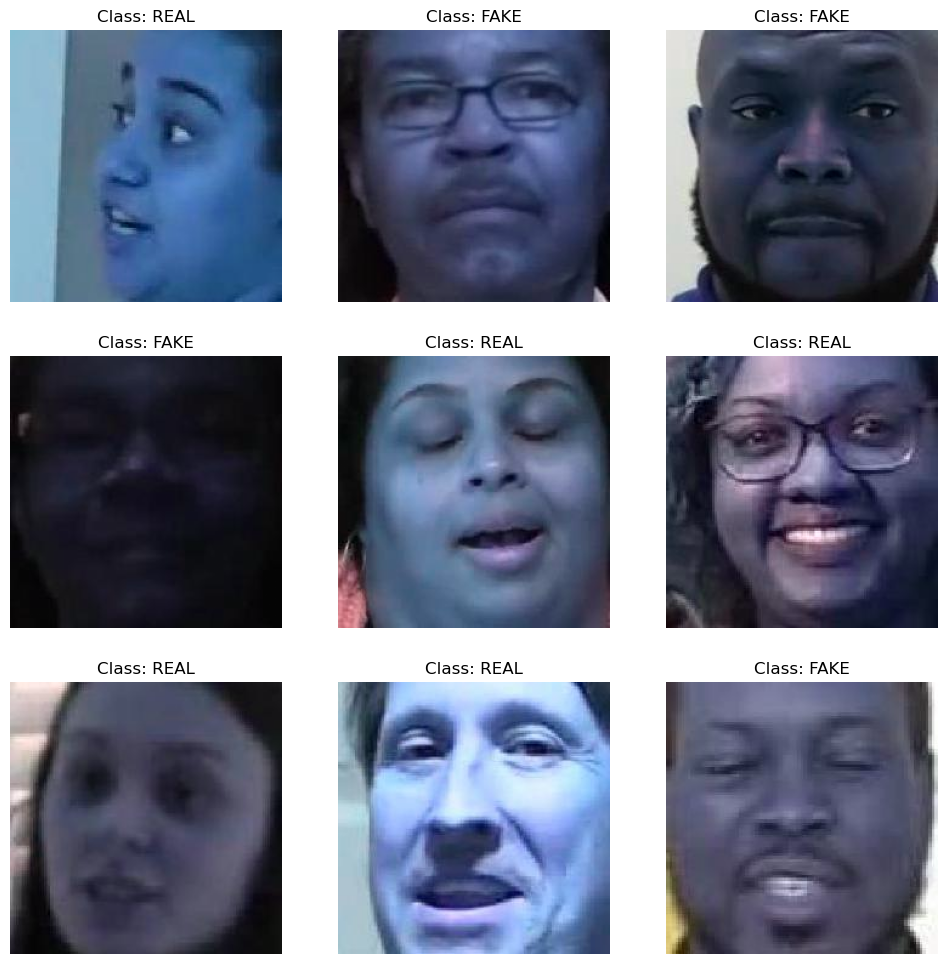

In [ ]:

# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

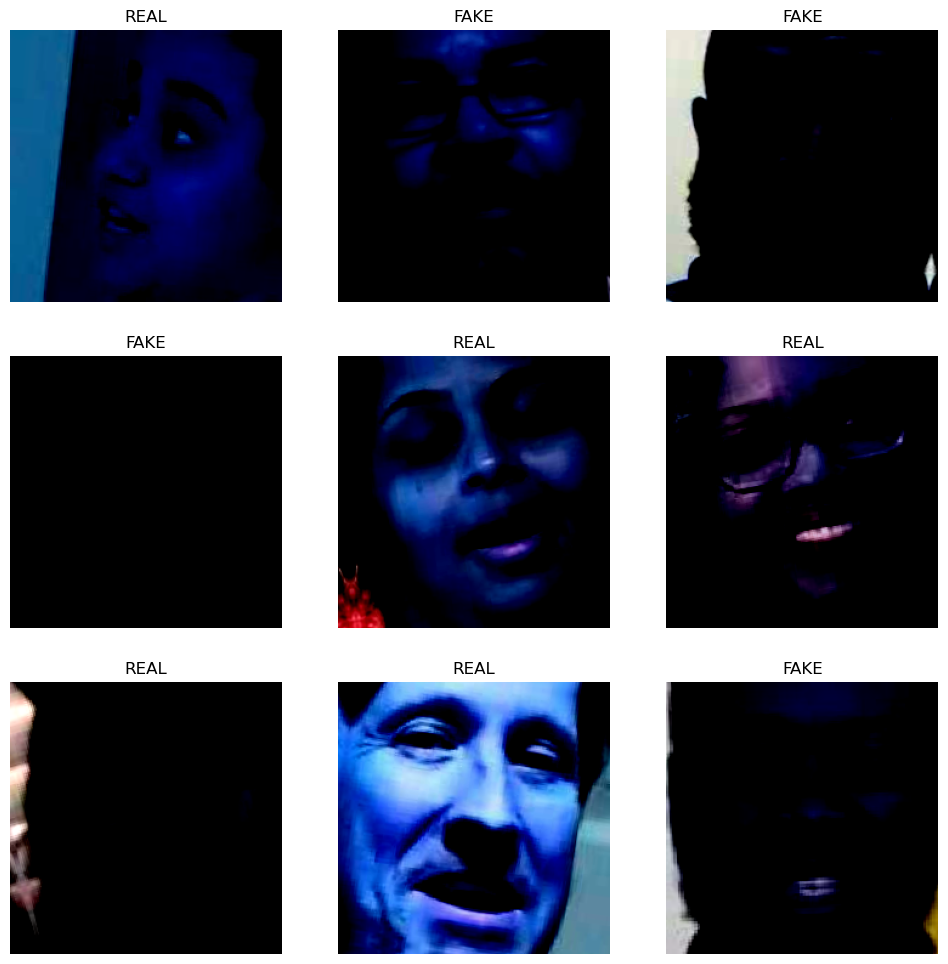

In [ ]:
# extra code – displays the same first 9 images, after augmentation

# Define a function to display images with labels
def show_images(images, labels):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis('off')
    plt.show()

# Get a batch of images from the validation set
for images, labels in valid_set.take(1):
    # Apply data augmentation
    augmented_images = data_augmentation(images, training=True)
    # Convert labels from binary to class names
    class_labels = ['REAL' if label == 0 else 'FAKE' for label in labels.numpy()]
    # Get the first 9 augmented images and their corresponding labels
    augmented_images, class_labels = augmented_images[:9], class_labels[:9]
    # Display the augmented images with labels
    show_images(augmented_images, class_labels)


MAKING A MODEL FROM SCRATCH (CNN AND RNN ARCHETECTURE )

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)
#CNN
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(filters=64, kernel_size=7, padding="same",activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same",activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=["accuracy"])
model.summary()
history = model.fit(X_train, y_train, epochs=5,batch_size=64,validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 401408)            0         
                                                                 
 dense_3 (Dense)             (None, 128)              

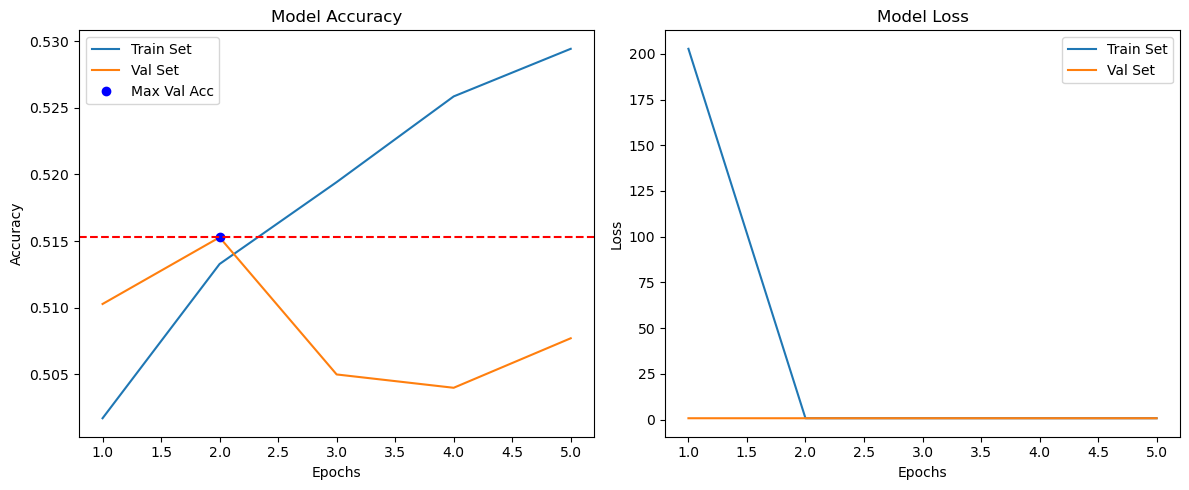

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

# Get the maximum validation accuracy and the epoch where it occurred
val_acc_max = max(history.history['val_accuracy'])
val_acc_max_idx = history.history['val_accuracy'].index(val_acc_max) + 1

# Plot the accuracy and loss curves for the training and validation sets
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.plot(val_acc_max_idx, val_acc_max, 'bo', label='Max Val Acc')
plt.axhline(y=val_acc_max, color='r', linestyle='--')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


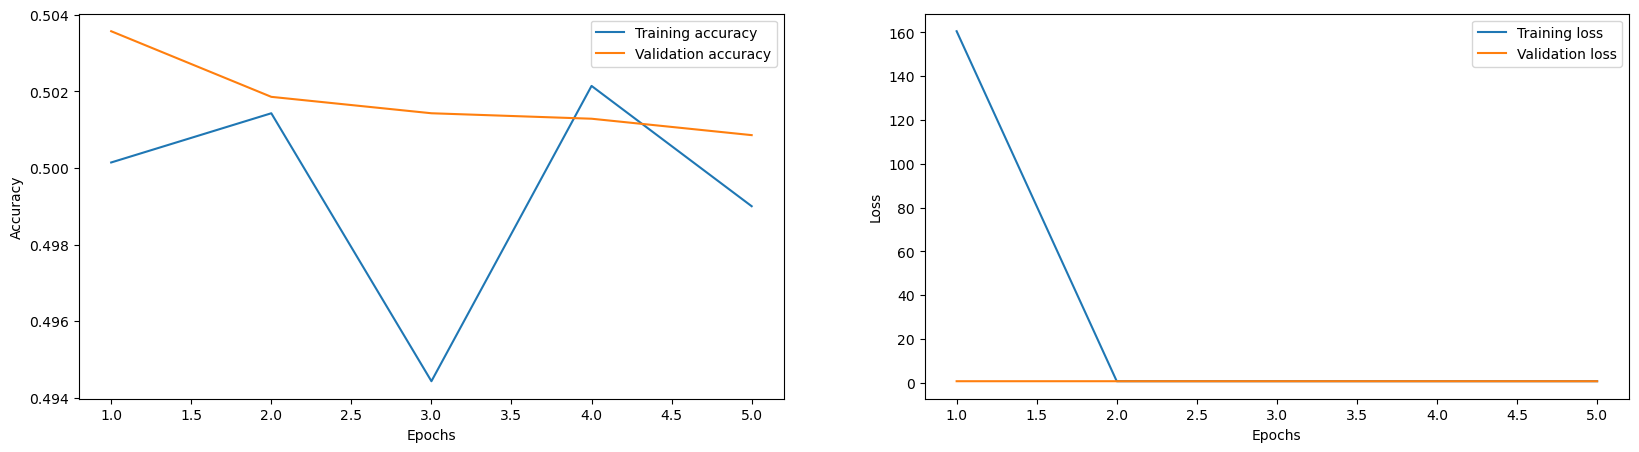

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['accuracy', 'loss']
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
epochs_range = range(1, len(history.epoch) + 1)
for i, metric in enumerate(metrics):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']
    axes[i].plot(epochs_range, train_metric, label=f'Training {metric}')
    axes[i].plot(epochs_range, val_metric, label=f'Validation {metric}')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].legend(loc='best')
plt.show()






In [ ]:
y_pred = model.predict([X_test])

from sklearn.metrics import classification_report, confusion_matrix

y_true = y_test

y_pred = np.round(y_pred).flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


NameError: ignored

In [ ]:
y_pred = (y_pred > 0.5)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

Accuracy:  0.5076666666666667
Precision:  0.5047208538587848
Recall:  0.8196666666666667
F1 Score:  0.6247459349593496


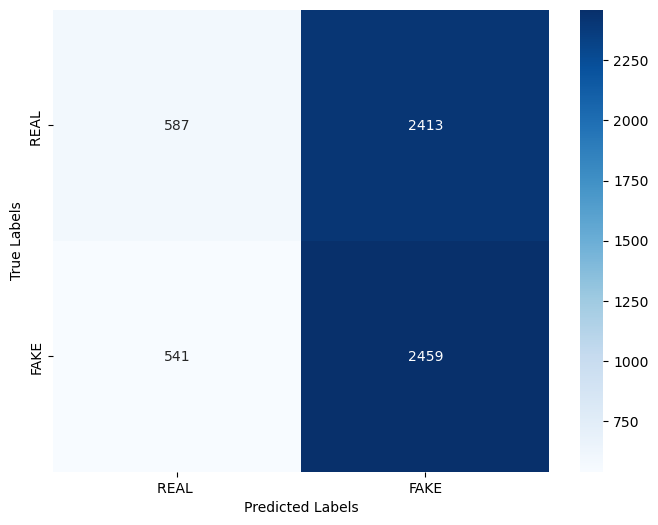

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Define the class labels
class_labels = ['REAL ', 'FAKE']

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [ ]:
y_pred = model.predict([X_train])

from sklearn.metrics import classification_report, confusion_matrix

y_true = y_train

y_pred = np.round(y_pred).flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

y_pred = (y_pred > 0.5)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_train, y_pred))
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))
print("F1 Score: ", f1_score(y_train, y_pred))


219/219 [==============================] - 5s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      3500
           1       0.85      0.00      0.01      3500

    accuracy                           0.50      7000
   macro avg       0.68      0.50      0.34      7000
weighted avg       0.68      0.50      0.34      7000

Confusion Matrix:
[[3497    3]
 [3483   17]]
Accuracy:  0.502
Precision:  0.85
Recall:  0.004857142857142857
F1 Score:  0.009659090909090909


LOADING A PRE-TRAINED MODEL

In [ ]:
# Set the random seed for reproducibility
import tensorflow as tf
tf.random.set_seed(42)

# Load the pre-trained Xception model with imagenet weights
base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False)


# Add some custom layers on top of the base model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Define the model
model1 = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set the last few layers to be trainable
for layer in base_model.layers[56:]:
    layer.trainable = True


# Set callbacks
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
learning_rate_scheduler = ReduceLROnPlateau(factor=0.1, patience=2)



# Compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Fit the model
history = model1.fit(train_set, validation_data=valid_set, epochs=5, callbacks=[early_stopping])


# Evaluate the model on the test set
model1.evaluate(test_set)

Epoch 1/5
110/110 [==============================] - 121s 956ms/step - loss: 0.0681 - accuracy: 0.9767 - val_loss: 1.1242 - val_accuracy: 0.7684
Epoch 2/5
110/110 [==============================] - 105s 953ms/step - loss: 0.0625 - accuracy: 0.9786 - val_loss: 0.8814 - val_accuracy: 0.7923
Epoch 3/5
110/110 [==============================] - 105s 951ms/step - loss: 0.0596 - accuracy: 0.9781 - val_loss: 0.6417 - val_accuracy: 0.8180
Epoch 4/5
110/110 [==============================] - 105s 951ms/step - loss: 0.0379 - accuracy: 0.9880 - val_loss: 0.8473 - val_accuracy: 0.8014
Epoch 5/5
94/94 [==============================] - 26s 278ms/step - loss: 0.7569 - accuracy: 0.8193


[0.7569061517715454, 0.8193333148956299]

EVALUATION

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true =y_test

# Get the predictions for the test set
y_pred = model1.predict(test_set).round().astype(int)
print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred))
print("Recall: ", recall_score(y_true, y_pred))
print("F1 Score: ", f1_score(y_true, y_pred))


94/94 [==============================] - 24s 258ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      3000
           1       0.87      0.76      0.81      3000

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000

Confusion Matrix:
[[2647  353]
 [ 731 2269]]
Accuracy:  0.8193333333333334
Precision:  0.8653699466056446
Recall:  0.7563333333333333
F1 Score:  0.8071860547847741


94/94 [==============================] - 26s 272ms/step


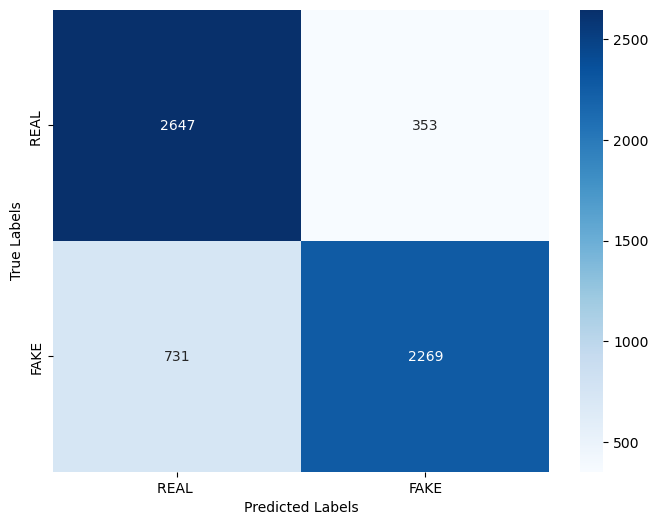

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions for the test set
y_pred = model1.predict(test_set).round().astype(int)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Define the class labels
class_labels = ['REAL ', 'FAKE']

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model1.predict(train_set).round().astype(int)
y_true = y_train

y_pred = np.round(y_pred).flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

y_pred = (y_pred > 0.5)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_train, y_pred))
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))
print("F1 Score: ", f1_score(y_train, y_pred))

110/110 [==============================] - 31s 283ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      3500
           1       0.49      0.48      0.49      3500

    accuracy                           0.49      7000
   macro avg       0.49      0.49      0.49      7000
weighted avg       0.49      0.49      0.49      7000

Confusion Matrix:
[[1733 1767]
 [1808 1692]]
Accuracy:  0.48928571428571427
Precision:  0.4891587163920208
Recall:  0.48342857142857143
F1 Score:  0.48627676390285957


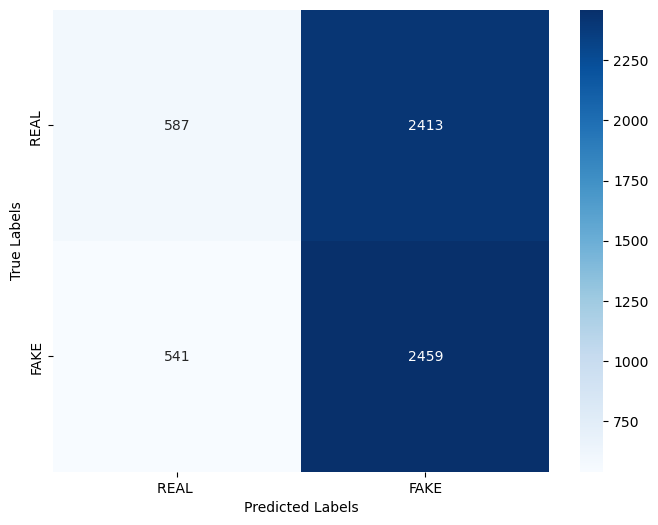

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Define the class labels
class_labels = ['REAL ', 'FAKE']

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model1.predict(valid_set).round().astype(int)
y_true = y_val
y_pred = np.round(y_pred).flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

y_pred = (y_pred > 0.5)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred))
print("Recall: ", recall_score(y_true, y_pred))
print("F1 Score: ", f1_score(y_true, y_pred))

110/110 [==============================] - 30s 275ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      3500
           1       0.86      0.73      0.79      3500

    accuracy                           0.81      7000
   macro avg       0.82      0.81      0.81      7000
weighted avg       0.82      0.81      0.81      7000

Confusion Matrix:
[[3096  404]
 [ 934 2566]]
Accuracy:  0.8088571428571428
Precision:  0.863973063973064
Recall:  0.7331428571428571
F1 Score:  0.7931993817619784


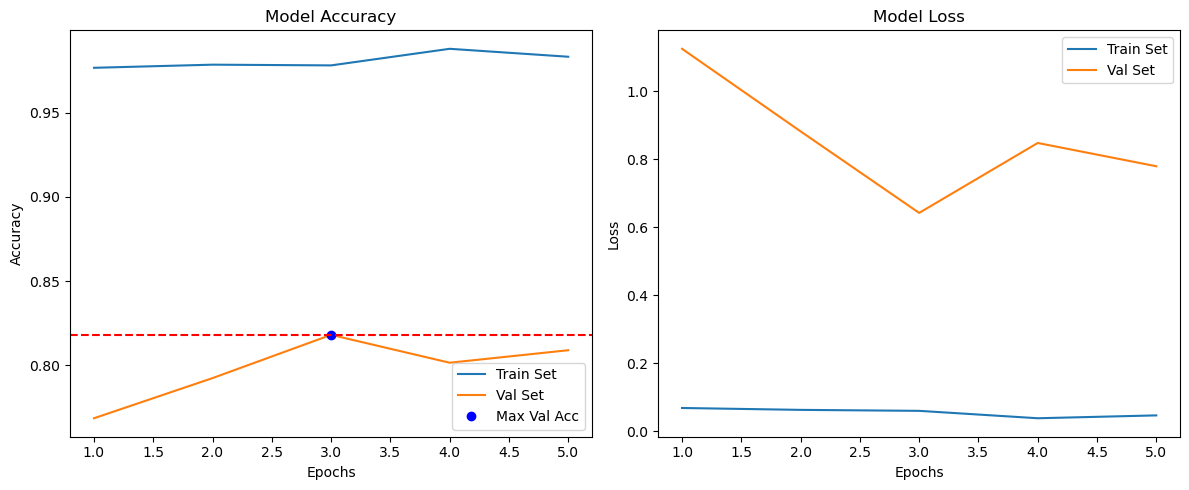

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

# Get the maximum validation accuracy and the epoch where it occurred
val_acc_max = max(history.history['val_accuracy'])
val_acc_max_idx = history.history['val_accuracy'].index(val_acc_max) + 1

# Plot the accuracy and loss curves for the training and validation sets
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.plot(val_acc_max_idx, val_acc_max, 'bo', label='Max Val Acc')
plt.axhline(y=val_acc_max, color='r', linestyle='--')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()



In [ ]:
model.save('deepfake_cnn-image.h5')

DISAPLYING FEATURE EXTRACTION AS HEATMAPS

1/1 [==============================] - 2s 2s/step


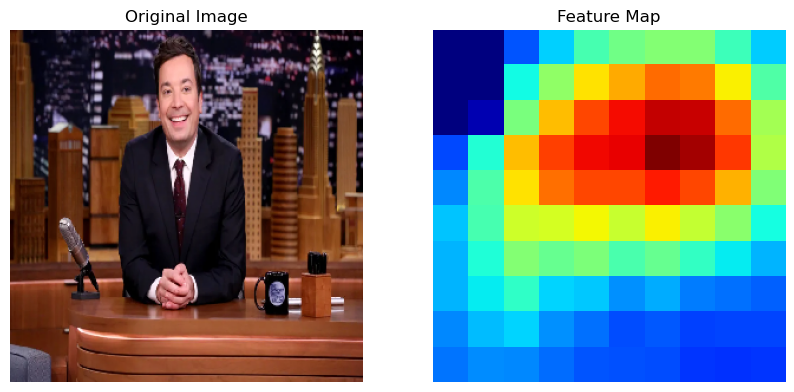

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

# create the model
model = Model(inputs=base_model.input, outputs=output)

# get the feature maps from the base model
features_model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# load an image and preprocess it
img_path = '/kaggle/input/test-image/Screenshot 2023-04-01 at 3.52.15 PM.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = tf.keras.applications.xception.preprocess_input(x)

# extract the features from the image
features = features_model.predict(tf.expand_dims(x, axis=0))

# display the original image and the features side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# display the original image
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

# display the feature maps
axs[1].imshow(features[0, :, :, 0], cmap='jet')
axs[1].set_title('Feature Map')
axs[1].axis('off')

plt.show()



1/1 [==============================] - 1s 718ms/step
[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.24755014 0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.59807605 0.         0.         ... 0.         0.
    0.        ]
   [0.49848026 0.         0.         ... 0.05026443 0.13645655
    0.20618364]
   [0.3823042  0.         0.06429747 ... 0.07255681 0.23523092
    0.24004382]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.43869612 0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.91543674 0.         0.         ... 0.         0.
    0.        ]
   [0.7689708  0.         0.         ... 0.05025665 0.
    0.        ]
   [0.5249617  0.         0.         ... 0.09560666 0.11416458
    0.15288725]]

  [[0.         0.         0.         ... 0.         0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in true_divide



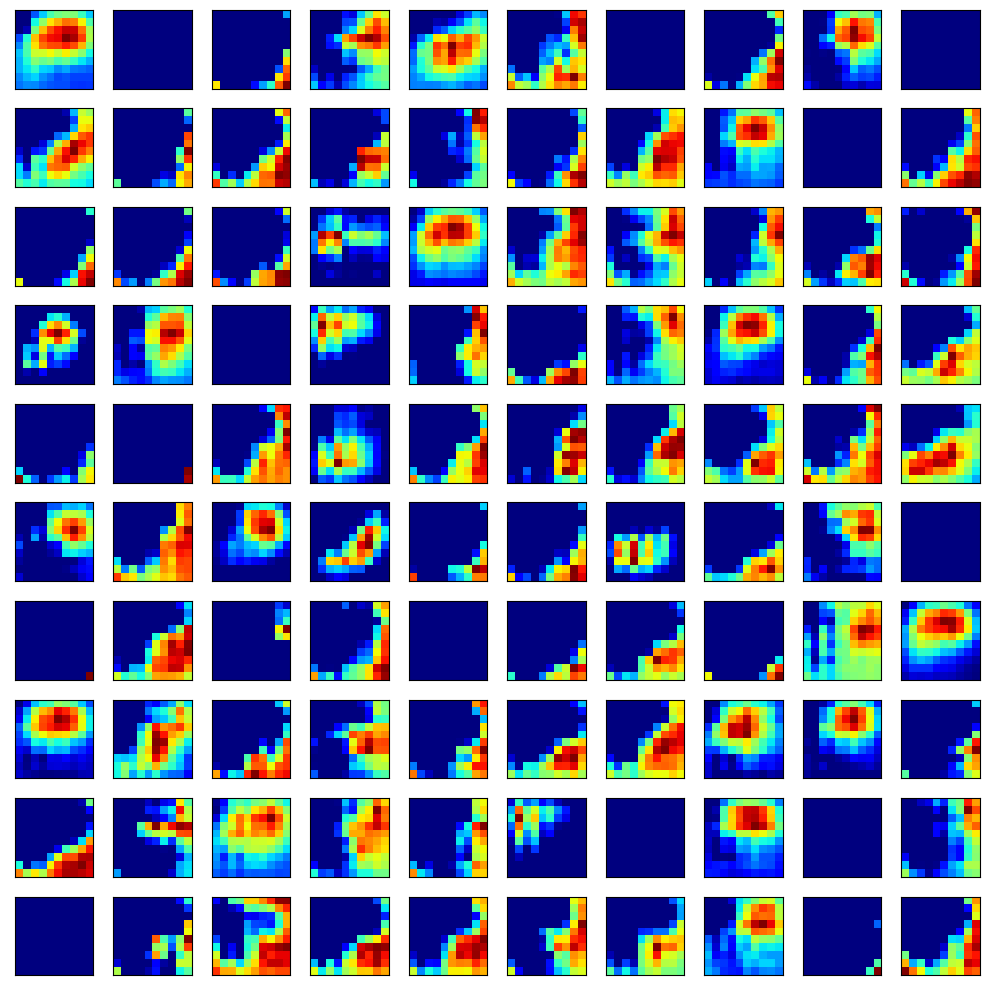

In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# create the model
model = Model(inputs=base_model.input, outputs=output)

# get the feature maps from the base model
features_model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# load an image and preprocess it
img_path = '/kaggle/input/test-image/Screenshot 2023-04-01 at 3.52.15 PM.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = tf.keras.applications.xception.preprocess_input(x)

# extract the features from the image
features = features_model.predict(tf.expand_dims(x, axis=0))

# display the features
print(features)
fig = plt.figure(figsize=(10, 10))
for i in range(1, 101):
    ax = fig.add_subplot(10, 10, i)
    feature_map = features[0, :, :, i-1]
    feature_map -= feature_map.min()
    feature_map /= feature_map.max()
    feature_map *= 255
    feature_map = np.uint8(feature_map)
    plt.imshow(feature_map, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

